In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange
from tqdm import tqdm

# Setting Constants
x_0 = 0
y_0 = 0
t_i = 0
t_f = 8

mass = 1
steps = 130  # Reduced from 800 - fewer points to update
numb_paths = 1000

times = np.linspace(t_i, t_f, steps)
dt = times[1] - times[0]

# Position generating function
def Pos_Gen(x0, xN, Steps, dt):
    path = np.zeros(Steps)
    path[0] = x0

    for i in range(1, Steps):
        path[i] = path[i-1] + np.random.normal(0, np.sqrt(dt))

    # shift so endpoint is exactly xN
    path += np.linspace(0, xN - path[-1], Steps)
    return path

# Vectorized interior point update
def metropolis_path_update_vectorised(paths, times, mass, potential, i, sigma_prop):
    dt = times[1] - times[0]

    x_old = paths[:, i]
    x_prev = paths[:, i - 1]
    x_next = paths[:, i + 1]

    x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)

    # Kinetic term change
    dS_kin = (mass / (2*dt)) * (
        (x_new - x_prev)**2 + (x_next - x_new)**2
        - (x_old - x_prev)**2 - (x_next - x_old)**2
    )

    # Potential term change
    x_mid_prev_old = 0.5 * (x_prev + x_old)
    x_mid_next_old = 0.5 * (x_old + x_next)
    x_mid_prev_new = 0.5 * (x_prev + x_new)
    x_mid_next_new = 0.5 * (x_new + x_next)

    dS_pot = dt * (
        potential(x_mid_prev_new) + potential(x_mid_next_new)
        - potential(x_mid_prev_old) - potential(x_mid_next_old)
    )

    dS = dS_kin + dS_pot

    accept = np.random.rand(len(x_old)) < np.exp(-dS)
    paths[accept, i] = x_new[accept]

    return np.mean(accept)

# NEW: Endpoint update function
def metropolis_endpoint_update_vectorised(paths, times, mass, potential, sigma_prop):
    """
    Vectorised Metropolis update for endpoint (last point) of all paths.
    """
    dt = times[1] - times[0]
    i = paths.shape[1] - 1  # last point

    x_old = paths[:, i]
    x_prev = paths[:, i-1]

    # symmetric proposal
    x_new = x_old + np.random.normal(0, sigma_prop, size=x_old.shape)

    # Kinetic term change (only one neighbor)
    dS_kin = (mass / (2*dt)) * ((x_new - x_prev)**2 - (x_old - x_prev)**2)

    # Potential at midpoint between second-to-last and endpoint
    x_mid_old = 0.5 * (x_prev + x_old)
    x_mid_new = 0.5 * (x_prev + x_new)
    dS_pot_mid = dt * (potential(x_mid_new) - potential(x_mid_old))

    # CRITICAL FIX: Also include potential at the endpoint itself (half weight)
    dS_pot_end = 0.5 * dt * (potential(x_new) - potential(x_old))

    dS = dS_kin + dS_pot_mid + dS_pot_end

    accept = np.random.rand(len(x_old)) < np.exp(-dS)
    paths[accept, i] = x_new[accept]

    return np.mean(accept)

# Full sweep function - BETTER optimization
def metropolis_sweep_vectorised(paths, times, mass, potential, sigma_prop, n_interior_updates=5):
    """
    Do a partial sweep: update only n_interior_updates random interior points
    plus always update the endpoint.
    """
    n_steps = paths.shape[1]

    # Randomly select which interior points to update
    interior_indices = np.random.choice(range(1, n_steps-1), size=n_interior_updates, replace=False)

    acceptances = []
    for i in interior_indices:
        acc = metropolis_path_update_vectorised(paths, times, mass, potential, i, sigma_prop)
        acceptances.append(acc)

    # Always update endpoint
    endpoint_accept = metropolis_endpoint_update_vectorised(
        paths, times, mass, potential, sigma_prop
    )

    return np.mean(acceptances) if acceptances else 0.0, endpoint_accept

# Potentials

In [4]:
# Potential
def x_potential(x):
    return 1/2 * x**2

def y_potential(x):
    return 1000 * x**4
#
# def y_potential(x):
#     return 1000 * ((x-1)**2 + (x+1)**2)

# X-Dimension Sampling

In [5]:
# Initialize paths (Brownian bridge from 0 to 0)
paths_x = np.array([
    Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

In [6]:
print(paths_x[0])

[ 0.          0.0821858  -0.02286841 -0.33457817 -0.49303766 -0.68803215
 -0.81503138 -0.99182371 -0.385234    0.07324003  0.2010691   0.58393281
  0.58793211  0.39999322  0.25716133  0.1459054   0.29933252  0.62842266
  0.84192214  0.55991169  0.48349362  0.40330175  0.50727873 -0.0088135
  0.03315271  0.11406636  0.43056484  0.98471851  1.00037512  0.8385471
  1.21350272  1.48330708  1.44856124  1.44109909  1.47380281  1.35185862
  1.01247039  1.32227322  1.66378522  1.86013291  1.60613654  2.21494925
  2.21144916  2.49210858  2.09412134  1.76170559  2.048291    2.52612955
  2.59019317  2.48347295  2.80049535  2.46634902  2.59376738  2.23701871
  2.12167296  1.81300416  2.24277067  2.14344362  1.8351215   1.8597461
  1.58707038  1.65623077  1.3868157   1.49802441  1.22970567  0.87481651
  0.90184091  1.06334293  0.88236463  1.13160628  0.91678055  1.35087846
  1.29299504  1.49807435  1.69144866  1.69546996  1.7224926   2.21287669
  2.42724864  2.71272729  2.72753709  2.79842442  2.78

Thermalizing...


Thermalising:  26%|██▌       | 129/500 [00:00<00:00, 629.61it/s]

Endpoint acceptance ≈ 0.513
Endpoint acceptance ≈ 0.515


Thermalising:  65%|██████▍   | 323/500 [00:00<00:00, 574.68it/s]

Endpoint acceptance ≈ 0.506
Endpoint acceptance ≈ 0.542


Thermalising: 100%|██████████| 500/500 [00:00<00:00, 623.35it/s]


Endpoint acceptance ≈ 0.521

Sampling...


Sampling:   0%|          | 21/5000 [00:00<00:07, 684.88it/s]

Endpoint acceptance ≈ 0.518


Sampling:   3%|▎         | 126/5000 [00:00<00:08, 590.67it/s]

Endpoint acceptance ≈ 0.537


Sampling:   5%|▍         | 234/5000 [00:00<00:07, 651.27it/s]

Endpoint acceptance ≈ 0.510


Sampling:   7%|▋         | 334/5000 [00:00<00:07, 651.69it/s]

Endpoint acceptance ≈ 0.527


Sampling:   9%|▊         | 436/5000 [00:00<00:06, 652.86it/s]

Endpoint acceptance ≈ 0.526


Sampling:  11%|█         | 535/5000 [00:00<00:06, 669.36it/s]

Endpoint acceptance ≈ 0.527


Sampling:  13%|█▎        | 638/5000 [00:00<00:06, 698.49it/s]

Endpoint acceptance ≈ 0.526


Sampling:  15%|█▍        | 739/5000 [00:01<00:06, 693.78it/s]

Endpoint acceptance ≈ 0.510


Sampling:  17%|█▋        | 835/5000 [00:01<00:06, 693.96it/s]

Endpoint acceptance ≈ 0.509


Sampling:  19%|█▊        | 936/5000 [00:01<00:05, 695.06it/s]

Endpoint acceptance ≈ 0.522


Sampling:  21%|██        | 1034/5000 [00:01<00:05, 664.86it/s]

Endpoint acceptance ≈ 0.514


Sampling:  23%|██▎       | 1128/5000 [00:01<00:05, 666.03it/s]

Endpoint acceptance ≈ 0.514


Sampling:  25%|██▍       | 1227/5000 [00:01<00:06, 614.28it/s]

Endpoint acceptance ≈ 0.512


Sampling:  26%|██▋       | 1325/5000 [00:02<00:05, 665.20it/s]

Endpoint acceptance ≈ 0.518


Sampling:  29%|██▊       | 1430/5000 [00:02<00:05, 642.18it/s]

Endpoint acceptance ≈ 0.522


Sampling:  31%|███       | 1534/5000 [00:02<00:05, 685.55it/s]

Endpoint acceptance ≈ 0.513


Sampling:  33%|███▎      | 1633/5000 [00:02<00:04, 684.71it/s]

Endpoint acceptance ≈ 0.527


Sampling:  35%|███▍      | 1732/5000 [00:02<00:04, 665.46it/s]

Endpoint acceptance ≈ 0.530


Sampling:  36%|███▋      | 1822/5000 [00:02<00:05, 629.24it/s]

Endpoint acceptance ≈ 0.550


Sampling:  39%|███▊      | 1927/5000 [00:02<00:04, 659.82it/s]

Endpoint acceptance ≈ 0.545


Sampling:  41%|████      | 2026/5000 [00:03<00:04, 595.41it/s]

Endpoint acceptance ≈ 0.545


Sampling:  43%|████▎     | 2129/5000 [00:03<00:04, 685.28it/s]

Endpoint acceptance ≈ 0.526


Sampling:  45%|████▍     | 2236/5000 [00:03<00:04, 607.59it/s]

Endpoint acceptance ≈ 0.556


Sampling:  47%|████▋     | 2339/5000 [00:03<00:03, 711.35it/s]

Endpoint acceptance ≈ 0.528


Sampling:  49%|████▊     | 2437/5000 [00:03<00:03, 668.38it/s]

Endpoint acceptance ≈ 0.537


Sampling:  51%|█████     | 2537/5000 [00:03<00:03, 703.09it/s]

Endpoint acceptance ≈ 0.546


Sampling:  53%|█████▎    | 2638/5000 [00:04<00:03, 742.07it/s]

Endpoint acceptance ≈ 0.528


Sampling:  55%|█████▍    | 2739/5000 [00:04<00:02, 773.32it/s]

Endpoint acceptance ≈ 0.498


Sampling:  57%|█████▋    | 2839/5000 [00:04<00:03, 709.78it/s]

Endpoint acceptance ≈ 0.518


Sampling:  59%|█████▉    | 2939/5000 [00:04<00:03, 681.62it/s]

Endpoint acceptance ≈ 0.542


Sampling:  61%|██████    | 3033/5000 [00:04<00:03, 641.61it/s]

Endpoint acceptance ≈ 0.517


Sampling:  63%|██████▎   | 3127/5000 [00:04<00:03, 621.87it/s]

Endpoint acceptance ≈ 0.506


Sampling:  65%|██████▍   | 3229/5000 [00:04<00:02, 645.33it/s]

Endpoint acceptance ≈ 0.497


Sampling:  67%|██████▋   | 3328/5000 [00:05<00:02, 657.83it/s]

Endpoint acceptance ≈ 0.512


Sampling:  69%|██████▊   | 3428/5000 [00:05<00:02, 663.42it/s]

Endpoint acceptance ≈ 0.524


Sampling:  71%|███████   | 3537/5000 [00:05<00:01, 732.53it/s]

Endpoint acceptance ≈ 0.543


Sampling:  73%|███████▎  | 3638/5000 [00:05<00:01, 687.44it/s]

Endpoint acceptance ≈ 0.548


Sampling:  75%|███████▍  | 3730/5000 [00:05<00:01, 649.09it/s]

Endpoint acceptance ≈ 0.524


Sampling:  77%|███████▋  | 3834/5000 [00:05<00:01, 654.47it/s]

Endpoint acceptance ≈ 0.529


Sampling:  79%|███████▉  | 3941/5000 [00:05<00:01, 716.28it/s]

Endpoint acceptance ≈ 0.517


Sampling:  81%|████████  | 4042/5000 [00:06<00:01, 673.42it/s]

Endpoint acceptance ≈ 0.510


Sampling:  83%|████████▎ | 4131/5000 [00:06<00:01, 537.32it/s]

Endpoint acceptance ≈ 0.534


Sampling:  85%|████████▍ | 4229/5000 [00:06<00:01, 733.21it/s]

Endpoint acceptance ≈ 0.554


Sampling:  87%|████████▋ | 4340/5000 [00:06<00:01, 641.68it/s]

Endpoint acceptance ≈ 0.528


Sampling:  89%|████████▊ | 4433/5000 [00:06<00:00, 698.00it/s]

Endpoint acceptance ≈ 0.520


Sampling:  91%|█████████ | 4543/5000 [00:06<00:00, 826.89it/s]

Endpoint acceptance ≈ 0.517


Sampling:  93%|█████████▎| 4643/5000 [00:06<00:00, 666.27it/s]

Endpoint acceptance ≈ 0.532


Sampling:  95%|█████████▍| 4735/5000 [00:07<00:00, 640.41it/s]

Endpoint acceptance ≈ 0.518


Sampling:  97%|█████████▋| 4839/5000 [00:07<00:00, 753.34it/s]

Endpoint acceptance ≈ 0.506


Sampling:  99%|█████████▉| 4942/5000 [00:07<00:00, 729.78it/s]

Endpoint acceptance ≈ 0.502


Sampling: 100%|██████████| 5000/5000 [00:07<00:00, 665.69it/s]



------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.7827 (expected ≈ 0.707)
Root mean square: 0.7827 (expected ≈ 0.707)


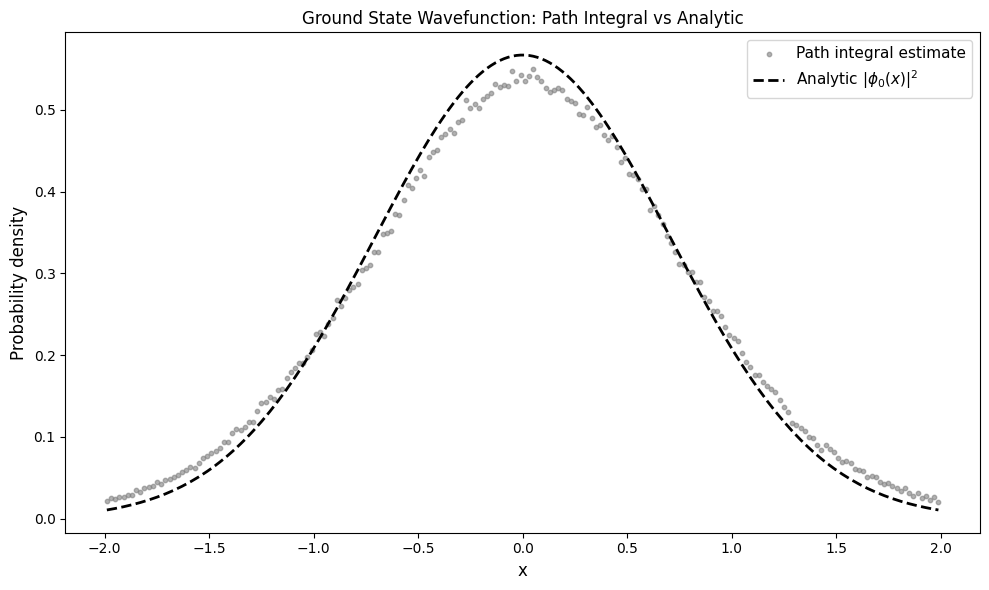

In [7]:
C = 1.8437008005694266
mid = paths_x.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_x = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_x, times, mass, x_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_x.append(paths_x[:, -1].copy())

samples_x = np.concatenate(samples_x)

# Compute PDF
x_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_x, bin_edges_x = np.histogram(samples_x, bins=x_bins)

x_centres = 0.5 * (bin_edges_x[1:] + bin_edges_x[:-1])
dx = np.diff(x_bins)[0]

pdf_x = pdf_unnormalised_x / np.sum(pdf_unnormalised_x * dx)

# Analytic PDF
phi_sq_analytic_x = (1 / np.sqrt(np.pi)) * np.exp(-x_centres ** 2)
phi_sq_analytic_x /= np.sum(phi_sq_analytic_x * dx)

# Statistics
mean_square_x = np.mean(samples_x**2)
rms = np.sqrt(mean_square_x)
std = np.std(samples_x)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_x * dx):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_x * dx):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(x_centres, pdf_x, label='Path integral estimate', s=10, alpha=0.6, color = 'grey')
plt.plot(x_centres, phi_sq_analytic_x, 'black',linestyle = '--', linewidth=2, label=r'Analytic $|\phi_0(x)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

# Y-Dimension

Thermalizing...


Thermalising:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_19956\618505141.py:60: RuntimeWarning: overflow encountered in exp
  accept = np.random.rand(len(x_old)) < np.exp(-dS)
Thermalising:  18%|█▊        | 92/500 [00:00<00:00, 474.32it/s]

Endpoint acceptance ≈ 0.311


Thermalising:  39%|███▉      | 197/500 [00:00<00:00, 464.10it/s]

Endpoint acceptance ≈ 0.321


Thermalising:  60%|█████▉    | 299/500 [00:00<00:00, 493.50it/s]

Endpoint acceptance ≈ 0.330


Thermalising:  80%|███████▉  | 398/500 [00:00<00:00, 492.33it/s]

Endpoint acceptance ≈ 0.353


Thermalising: 100%|█████████▉| 498/500 [00:01<00:00, 495.27it/s]

Endpoint acceptance ≈ 0.313


Thermalising: 100%|██████████| 500/500 [00:01<00:00, 478.45it/s]



Sampling...


Sampling:   2%|▏         | 96/5000 [00:00<00:10, 449.84it/s]

Endpoint acceptance ≈ 0.354


Sampling:   4%|▍         | 199/5000 [00:00<00:09, 490.93it/s]

Endpoint acceptance ≈ 0.356


Sampling:   6%|▌         | 295/5000 [00:00<00:10, 439.25it/s]

Endpoint acceptance ≈ 0.341


Sampling:   8%|▊         | 390/5000 [00:00<00:10, 454.08it/s]

Endpoint acceptance ≈ 0.327


Sampling:  10%|▉         | 494/5000 [00:01<00:09, 460.90it/s]

Endpoint acceptance ≈ 0.330


Sampling:  12%|█▏        | 592/5000 [00:01<00:09, 442.71it/s]

Endpoint acceptance ≈ 0.351


Sampling:  14%|█▍        | 698/5000 [00:01<00:08, 504.86it/s]

Endpoint acceptance ≈ 0.338


Sampling:  16%|█▌        | 798/5000 [00:01<00:08, 489.26it/s]

Endpoint acceptance ≈ 0.364


Sampling:  18%|█▊        | 889/5000 [00:01<00:09, 427.70it/s]

Endpoint acceptance ≈ 0.329


Sampling:  20%|█▉        | 988/5000 [00:02<00:08, 471.24it/s]

Endpoint acceptance ≈ 0.355


Sampling:  22%|██▏       | 1095/5000 [00:02<00:07, 508.51it/s]

Endpoint acceptance ≈ 0.310


Sampling:  24%|██▍       | 1197/5000 [00:02<00:08, 466.86it/s]

Endpoint acceptance ≈ 0.333


Sampling:  26%|██▌       | 1296/5000 [00:02<00:07, 485.47it/s]

Endpoint acceptance ≈ 0.341


Sampling:  28%|██▊       | 1396/5000 [00:03<00:07, 474.82it/s]

Endpoint acceptance ≈ 0.331


Sampling:  30%|██▉       | 1495/5000 [00:03<00:07, 487.59it/s]

Endpoint acceptance ≈ 0.347


Sampling:  32%|███▏      | 1600/5000 [00:03<00:06, 507.98it/s]

Endpoint acceptance ≈ 0.340


Sampling:  34%|███▍      | 1700/5000 [00:03<00:07, 469.76it/s]

Endpoint acceptance ≈ 0.353


Sampling:  36%|███▌      | 1797/5000 [00:03<00:06, 489.34it/s]

Endpoint acceptance ≈ 0.333


Sampling:  38%|███▊      | 1901/5000 [00:04<00:06, 447.70it/s]

Endpoint acceptance ≈ 0.320
Endpoint acceptance ≈ 0.341


Sampling:  42%|████▏     | 2098/5000 [00:04<00:06, 437.71it/s]

Endpoint acceptance ≈ 0.319


Sampling:  44%|████▍     | 2193/5000 [00:04<00:06, 460.39it/s]

Endpoint acceptance ≈ 0.340


Sampling:  46%|████▌     | 2293/5000 [00:04<00:05, 474.94it/s]

Endpoint acceptance ≈ 0.334


Sampling:  48%|████▊     | 2395/5000 [00:05<00:05, 450.10it/s]

Endpoint acceptance ≈ 0.327


Sampling:  50%|████▉     | 2494/5000 [00:05<00:05, 448.83it/s]

Endpoint acceptance ≈ 0.337


Sampling:  52%|█████▏    | 2597/5000 [00:05<00:05, 472.47it/s]

Endpoint acceptance ≈ 0.334


Sampling:  54%|█████▍    | 2693/5000 [00:05<00:05, 458.04it/s]

Endpoint acceptance ≈ 0.342


Sampling:  56%|█████▌    | 2793/5000 [00:05<00:04, 455.24it/s]

Endpoint acceptance ≈ 0.336


Sampling:  58%|█████▊    | 2894/5000 [00:06<00:04, 461.40it/s]

Endpoint acceptance ≈ 0.337


Sampling:  60%|█████▉    | 2993/5000 [00:06<00:04, 473.67it/s]

Endpoint acceptance ≈ 0.368


Sampling:  62%|██████▏   | 3093/5000 [00:06<00:04, 462.55it/s]

Endpoint acceptance ≈ 0.353


Sampling:  64%|██████▍   | 3192/5000 [00:06<00:03, 459.44it/s]

Endpoint acceptance ≈ 0.334


Sampling:  66%|██████▌   | 3294/5000 [00:07<00:03, 470.75it/s]

Endpoint acceptance ≈ 0.346


Sampling:  68%|██████▊   | 3391/5000 [00:07<00:03, 445.83it/s]

Endpoint acceptance ≈ 0.301


Sampling:  70%|██████▉   | 3489/5000 [00:07<00:03, 438.20it/s]

Endpoint acceptance ≈ 0.341


Sampling:  72%|███████▏  | 3597/5000 [00:07<00:02, 495.75it/s]

Endpoint acceptance ≈ 0.326


Sampling:  74%|███████▍  | 3700/5000 [00:07<00:02, 452.57it/s]

Endpoint acceptance ≈ 0.342


Sampling:  76%|███████▌  | 3795/5000 [00:08<00:02, 475.39it/s]

Endpoint acceptance ≈ 0.354


Sampling:  78%|███████▊  | 3894/5000 [00:08<00:02, 481.15it/s]

Endpoint acceptance ≈ 0.332


Sampling:  80%|███████▉  | 3998/5000 [00:08<00:02, 472.96it/s]

Endpoint acceptance ≈ 0.348


Sampling:  82%|████████▏ | 4097/5000 [00:08<00:01, 486.10it/s]

Endpoint acceptance ≈ 0.341


Sampling:  84%|████████▍ | 4198/5000 [00:08<00:01, 493.57it/s]

Endpoint acceptance ≈ 0.333


Sampling:  86%|████████▌ | 4299/5000 [00:09<00:01, 466.93it/s]

Endpoint acceptance ≈ 0.332


Sampling:  88%|████████▊ | 4394/5000 [00:09<00:01, 499.13it/s]

Endpoint acceptance ≈ 0.332


Sampling:  90%|████████▉ | 4494/5000 [00:09<00:01, 463.18it/s]

Endpoint acceptance ≈ 0.352


Sampling:  92%|█████████▏| 4594/5000 [00:09<00:00, 468.89it/s]

Endpoint acceptance ≈ 0.337


Sampling:  94%|█████████▍| 4694/5000 [00:10<00:00, 445.09it/s]

Endpoint acceptance ≈ 0.332


Sampling:  96%|█████████▌| 4792/5000 [00:10<00:00, 469.96it/s]

Endpoint acceptance ≈ 0.326


Sampling:  98%|█████████▊| 4898/5000 [00:10<00:00, 493.20it/s]

Endpoint acceptance ≈ 0.354


Sampling: 100%|█████████▉| 4999/5000 [00:10<00:00, 472.12it/s]

Endpoint acceptance ≈ 0.329


Sampling: 100%|██████████| 5000/5000 [00:10<00:00, 467.56it/s]



------ Results ------
Numerical PDF area: 1.00000
Analytic PDF area: 1.00000
Standard deviation: 0.1943 (expected ≈ 0.707)
Root mean square: 0.1943 (expected ≈ 0.707)


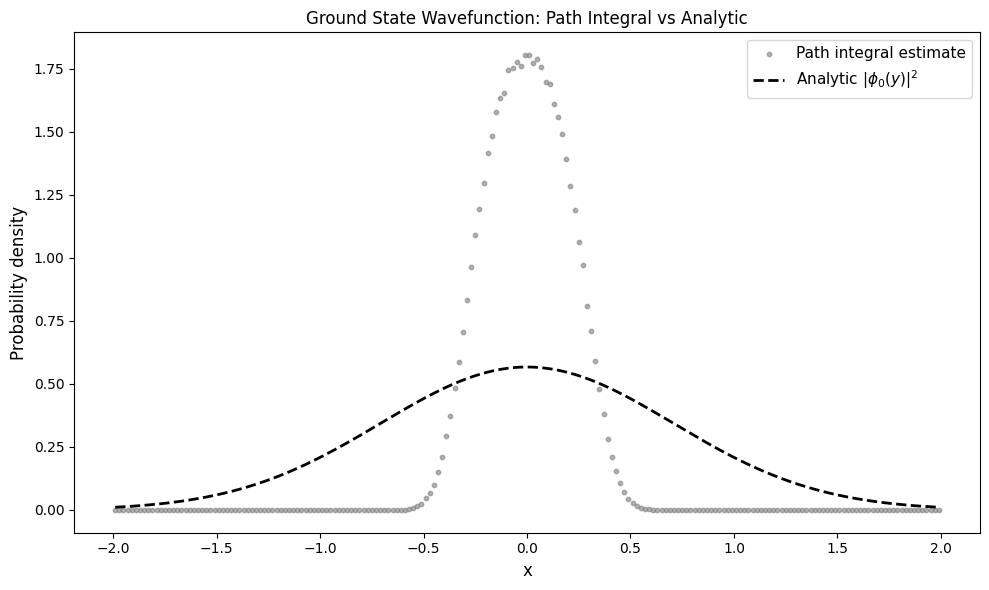

In [8]:
# Initialize paths (Brownian bridge from 0 to 0)
paths_y = np.array([
    Pos_Gen(0.0, 0.0, steps, dt)
    for _ in range(numb_paths)
])

C = 2.5
mid = paths_y.shape[1] // 2
thin = 10
sigma_prop = C * np.sqrt(dt)

# Thermalization
print("Thermalizing...")
for sweep in trange(500, desc="Thermalising", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_y, times, mass, y_potential, sigma_prop
    )

    if sweep % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

# Sampling
print("\nSampling...")
samples_y = []

for k in trange(5000, desc="Sampling", mininterval=0):
    acceptances, endpoint_accept = metropolis_sweep_vectorised(
        paths_y, times, mass, y_potential, sigma_prop
    )

    if k % 100 == 0:
        tqdm.write(f"Endpoint acceptance ≈ {endpoint_accept:.3f}")

    if k % thin == 0:
        samples_y.append(paths_y[:, -1].copy())

samples_y = np.concatenate(samples_y)

# Compute PDF
y_bins = np.linspace(-2, 2, 201)
pdf_unnormalised_y, bin_edges_y = np.histogram(samples_y, bins=y_bins)

y_centres = 0.5 * (bin_edges_y[1:] + bin_edges_y[:-1])
dy = np.diff(y_bins)[0]

pdf_y = pdf_unnormalised_y / np.sum(pdf_unnormalised_y * dy)

# Analytic PDF
phi_sq_analytic_y = (1 / np.sqrt(np.pi)) * np.exp(-y_centres ** 2)
phi_sq_analytic_y /= np.sum(phi_sq_analytic_y * dy)

# Statistics
mean_square_y = np.mean(samples_y**2)
rms = np.sqrt(mean_square_y)
std = np.std(samples_y)

print("\n------ Results ------")
print(f"Numerical PDF area: {np.sum(pdf_y * dy):.5f}")
print(f"Analytic PDF area: {np.sum(phi_sq_analytic_y * dy):.5f}")
print(f"Standard deviation: {std:.4f} (expected ≈ 0.707)")
print(f"Root mean square: {rms:.4f} (expected ≈ 0.707)")

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_centres, pdf_y, label='Path integral estimate', s=10, alpha=0.6, color = 'grey')
plt.plot(y_centres, phi_sq_analytic_y, 'black',linestyle = '--', linewidth=2, label=r'Analytic $|\phi_0(y)|^2$')
plt.xlabel('x', fontsize=12)
plt.ylabel('Probability density', fontsize=12)
plt.legend(fontsize=11)
plt.title('Ground State Wavefunction: Path Integral vs Analytic')

plt.tight_layout()
plt.show()

In [9]:
print(len(y_bins))
print(len(pdf_y))
print(len(y_centres))
print(len(samples_y))

print(len(x_bins))
print(len(pdf_x))
print(len(x_centres))
print(len(samples_x))

201
200
200
500000
201
200
200
500000


# 3D extension

In [10]:
# =========================
# 3D Joint Probability Density P(x,y)
# =========================
from scipy.ndimage import gaussian_filter

# 2D histogram
bins = np.linspace(-2, 2, 201)  # 100x100 bins
pdf_xy, x_edges, y_edges = np.histogram2d(samples_x, samples_y, bins=[bins, bins])

dx = x_edges[1] - x_edges[0]
dy = y_edges[1] - y_edges[0]

# Normalize so total probability = 1
pdf_xy = pdf_xy / np.sum(pdf_xy * dx * dy)

# Create meshgrid for plotting
x_centres = 0.5 * (x_edges[1:] + x_edges[:-1])
y_centres = 0.5 * (y_edges[1:] + y_edges[:-1])
X, Y = np.meshgrid(x_centres, y_centres)

# Smooth PDF
pdf_xy_smooth = gaussian_filter(pdf_xy, sigma=1)

#extract desired slices
ix0 = np.argmin(np.abs(x_edges[:-1] + dx/2 - 0))  # closest x bin center to 0
iy0 = np.argmin(np.abs(y_edges[:-1] + dy/2 - 0))  # closest y bin center to 0

pdf_xslice = pdf_xy[ix0, :]  # slice along y at x=0
pdf_yslice = pdf_xy[:, iy0]  # slice along x at y=0

pdf_xslice_smooth = pdf_xy_smooth[ix0, :]  # slice along y at x=0
pdf_yslice_smooth = pdf_xy_smooth[:, iy0]  # slice along x at y=0


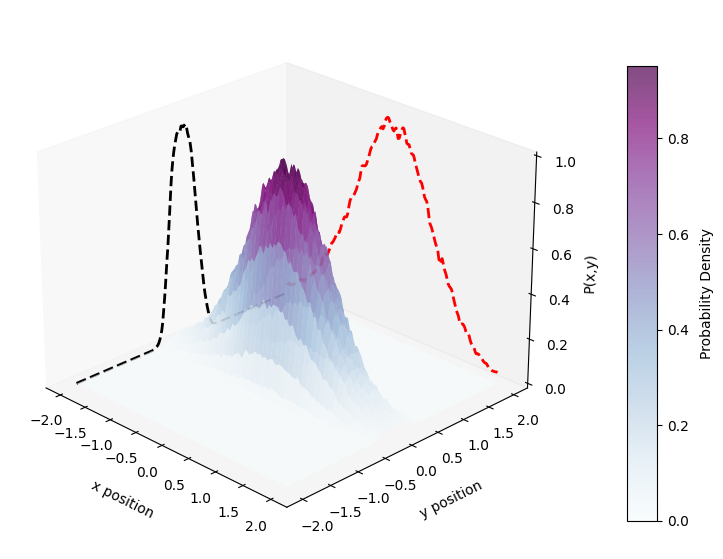

In [11]:
# 3D Plot
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')

# Smoothed surface
surf = ax.plot_surface(X, Y, pdf_xy_smooth.T, cmap='BuPu', edgecolor='none', alpha = 0.7)

ax.view_init(elev=25, azim=-45)
ax.grid(False)

# Left-hand colorbar
cbar_ax = fig.add_axes([0.86, 0.15, 0.03, 0.65])
cbar = fig.colorbar(surf, cax=cbar_ax, orientation='vertical')
cbar.set_label("Probability Density", labelpad=8)

# Back walls for slice projections
x_wall_back = np.min(x_edges)
y_wall_back = np.max(y_centres)

# Slice along y at x=0
ax.plot(np.full_like(y_centres, x_wall_back), y_centres, pdf_xslice_smooth,
        color='black', linewidth=2, linestyle='--', label='x=0 slice')

# Slice along x at y=0
ax.plot(x_centres, np.full_like(x_centres, y_wall_back), pdf_yslice_smooth,
        color='red', linewidth=2, linestyle='--', label='y=0 slice')

# Labels
ax.set_xlabel('x position', labelpad=10)
ax.set_ylabel('y position', labelpad=10)
ax.set_zlabel('P(x,y)', labelpad=3, rotation=90)
ax.zaxis.label.set_clip_on(False)
ax.zaxis.set_label_coords(1, 0.5, 0)  # manually position z-label
# Adjust layout manually to show z-label


plt.show()
